In [1]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
figformat = 'png'

In [4]:
ampli = Parameter("amplitude", value = 1e-12)
dataset_asimov = Dataset_load.create_asimov(source = "PKSflare", model = 'pl', parameters = Parameters([ampli]))
point_spatial_model = dataset_asimov.models[0].spatial_model

gaussian_spatial_model = GaussianSpatialModel(lon_0 = point_spatial_model.lon_0,
                                             lat_0 = point_spatial_model.lat_0,
                                             sigma = 0.5*u.deg)
model = SkyModel(spatial_model = gaussian_spatial_model.copy(),
                 spectral_model= dataset_asimov.models[0].spectral_model.copy(),
                 name = "source")
dataset_asimov.models = Models([model.copy(), dataset_asimov.background_model])
dataset_asimov.counts = dataset_asimov.npred()

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


In [5]:
dataset_asimov_cl = dataset_asimov.copy()
dataset_asimov_cl.models = Models([model.copy(), FoVBackgroundModel(dataset_name = dataset_asimov_cl.name)])
print(dataset_asimov_cl.models)

DatasetModels

Component 0: SkyModel

  Name                      : KhJPNZD1
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         
    sigma                         :      0.500   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : RpF4FQw3-bkg
  Datasets names            : ['RpF4FQw3']
  Spectral model type       : PowerLawNormSpectra

<WCSAxes: >

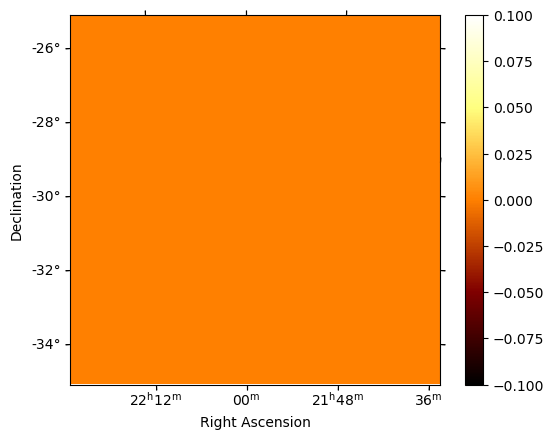

In [6]:
(dataset_asimov.counts- dataset_asimov_cl.counts).sum_over_axes().plot(add_cbar =1)

## PSF Model

In [7]:
from gammapy.modeling.models.IRF import PSFIRFModel, IRFModels

In [8]:
psf_model =PSFIRFModel(sigma=0.)
irf_models = IRFModels(psf_model=psf_model,
                      datasets_names=dataset_asimov.name)

In [9]:
dataset_asimov.models = Models([dataset_asimov.models[0], irf_models, dataset_asimov.background_model])
print(dataset_asimov.models)
dataset_asimov.models.parameters['sigma_psf'].min = 0 
sigma_ass = 1e-12
dataset_asimov.penalising_invcovmatrix = [[1/sigma_ass**2]]

DatasetModels

Component 0: SkyModel

  Name                      : 24KfVrf6
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         
    sigma                         :      0.500   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: IRFModels

  Name                      : 1nZ1RO5N-irf
  Datasets names            : 1nZ1RO5N
  EReco  model type         : 
  Eff area  model type      : 


compute gaussian for  sigma 1e-3 +  0.001


<WCSAxes: >

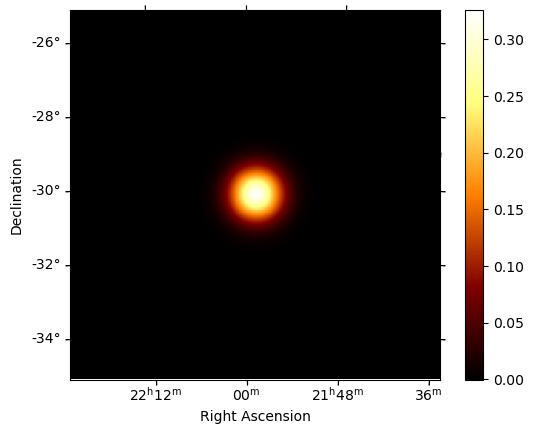

In [10]:
npred = dataset_asimov.npred_signal()
npred.sum_over_axes().plot(add_cbar =1)

## Prior Term

[1.00000000e-05 2.37137371e-05 5.62341325e-05 1.33352143e-04
 3.16227766e-04 7.49894209e-04 1.77827941e-03 4.21696503e-03
 1.00000000e-02 2.37137371e-02 5.62341325e-02 1.33352143e-01
 3.16227766e-01 7.49894209e-01 1.77827941e+00 4.21696503e+00
 1.00000000e+01]
compute gaussian for  sigma 1e-3 +  1e-05
compute gaussian for  sigma 1e-3 +  2.3713737056616554e-05
compute gaussian for  sigma 1e-3 +  5.623413251903491e-05
compute gaussian for  sigma 1e-3 +  0.0001333521432163324
compute gaussian for  sigma 1e-3 +  0.00031622776601683794
compute gaussian for  sigma 1e-3 +  0.0007498942093324559
compute gaussian for  sigma 1e-3 +  0.0017782794100389228
compute gaussian for  sigma 1e-3 +  0.004216965034285823
compute gaussian for  sigma 1e-3 +  0.01
compute gaussian for  sigma 1e-3 +  0.023713737056616554
compute gaussian for  sigma 1e-3 +  0.05623413251903491
compute gaussian for  sigma 1e-3 +  0.1333521432163324
compute gaussian for  sigma 1e-3 +  0.31622776601683794
compute gaussian for  sig

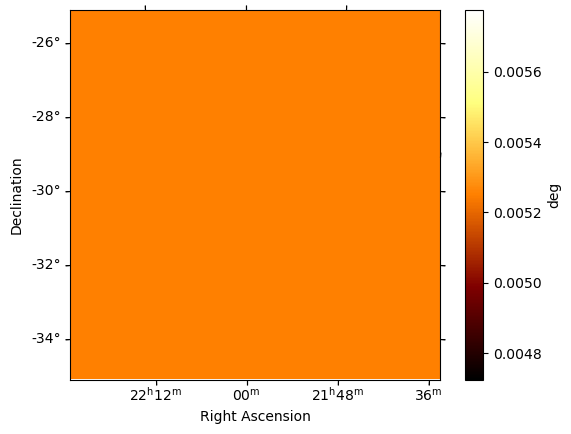

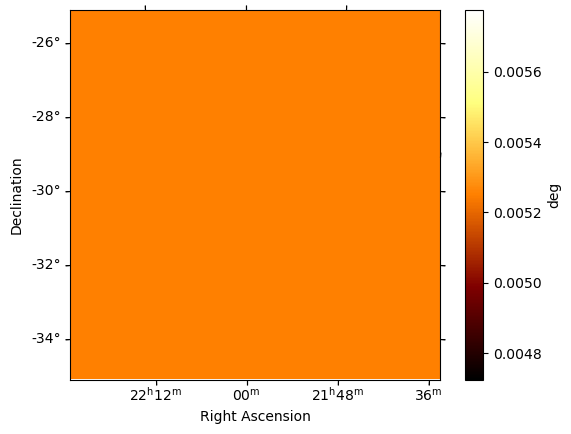

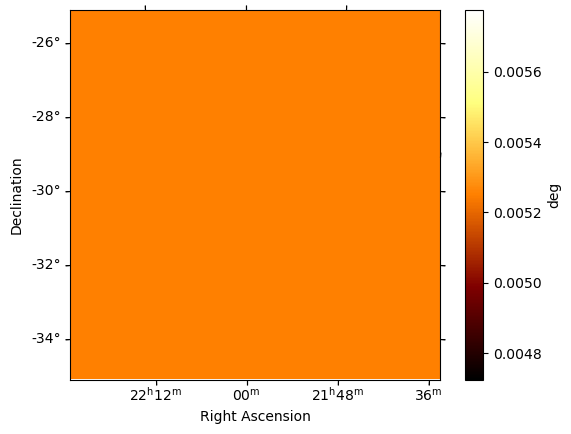

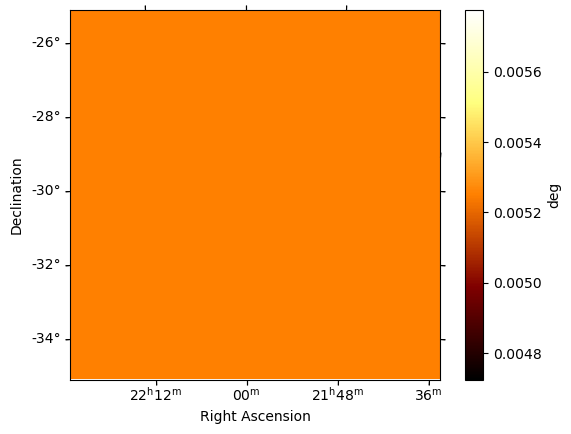

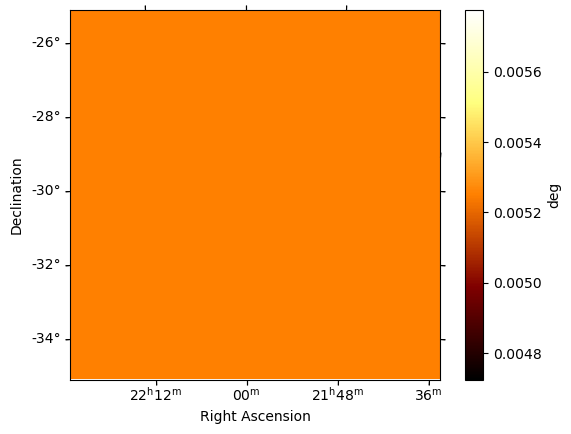

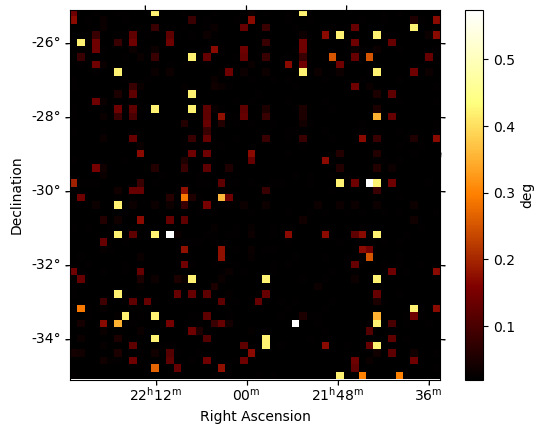

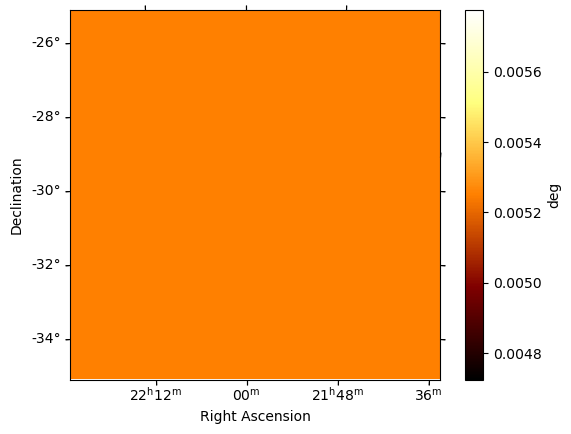

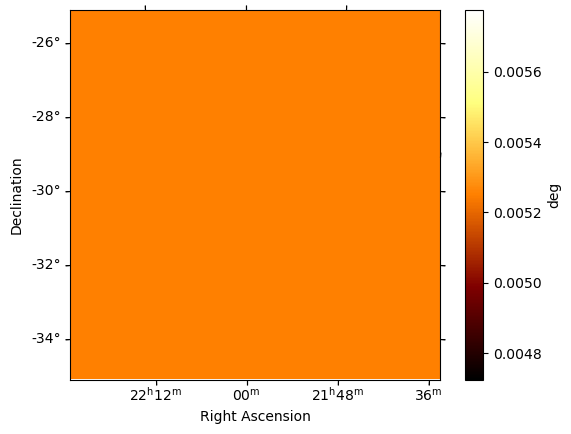

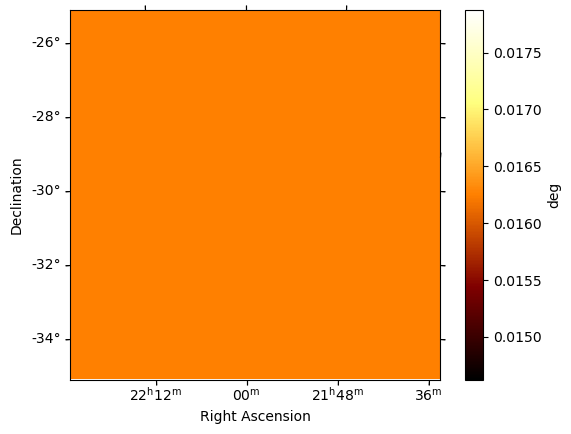

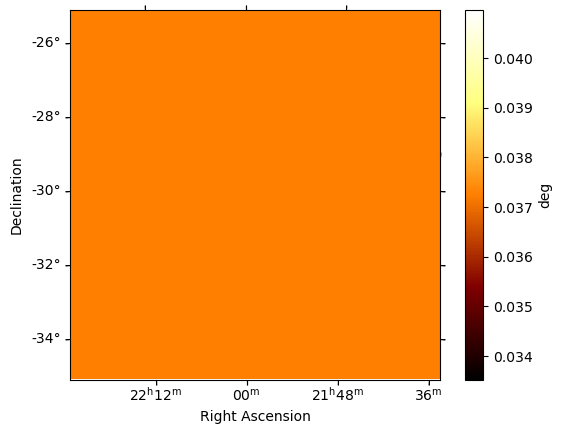

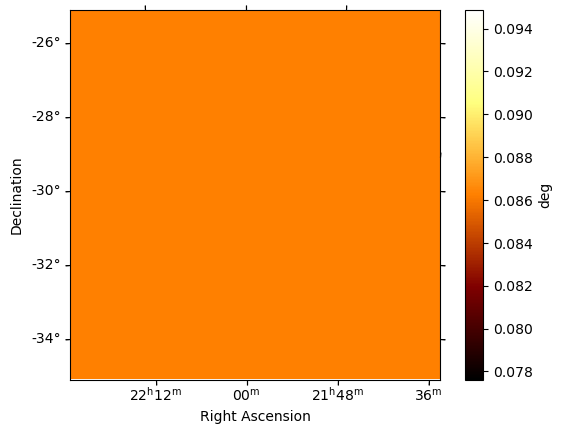

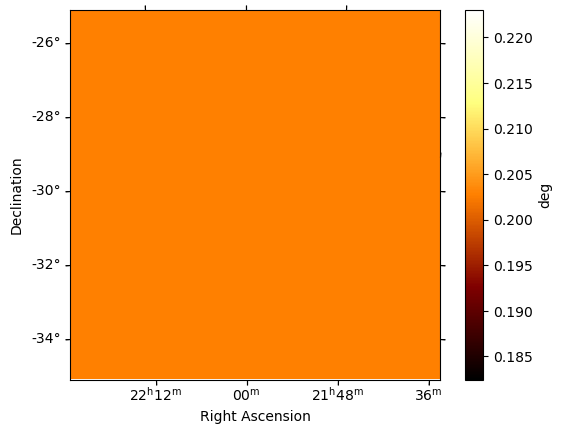

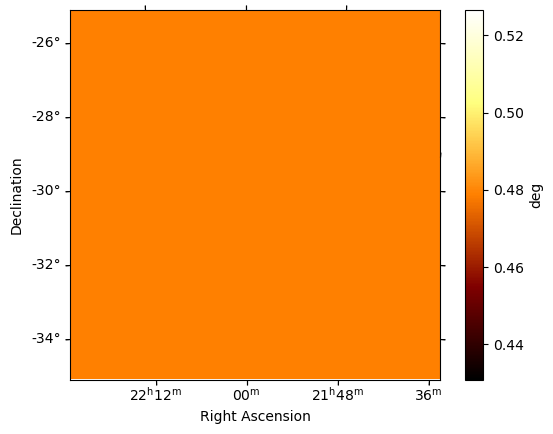

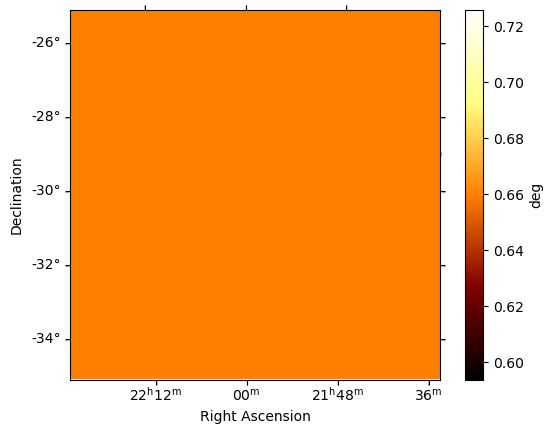

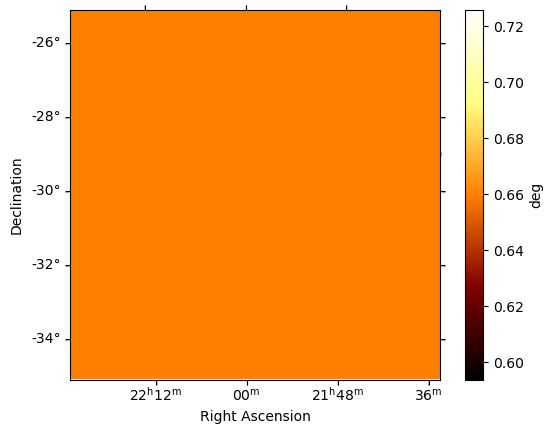

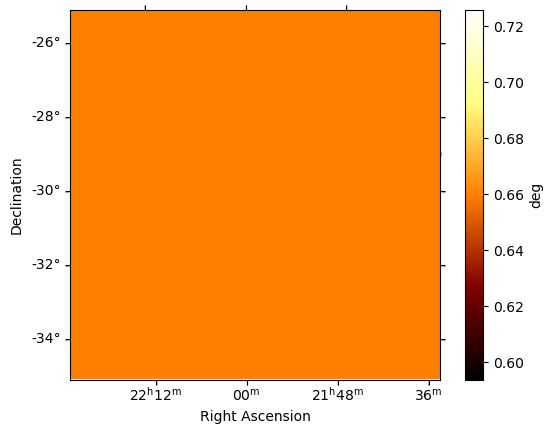

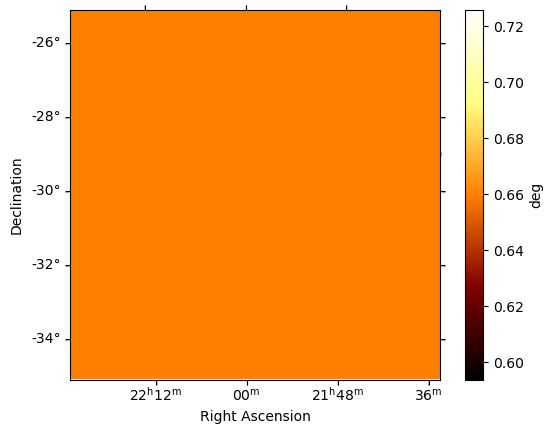

In [22]:
ss = np.logspace(-5,1, 17)
print(ss)
vals = []
vals_std = []
with dataset_asimov.models.parameters.restore_status():
    for s in ss:
    
        dataset_asimov.models.parameters['sigma_psf'].value = s
        plt.figure()
        map_ =      dataset_asimov.npred_gaussian_psf_map().containment_radius_map(energy_true = 1*u.TeV)
        map_.plot(add_cbar = 1)
        val =np.mean(map_.data.flatten())
        std =np.std(map_.data.flatten())
        
        vals.append(val)
        vals_std.append(std)
    

<WCSAxes: >

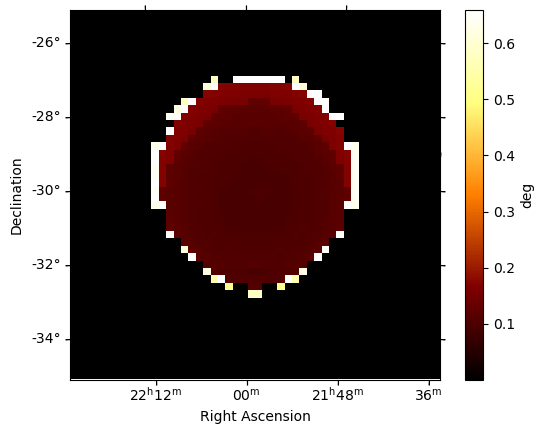

In [26]:
dataset_asimov_cl.psf.containment_radius_map(energy_true = 1*u.TeV).plot(add_cbar = 1)

Text(0, 0.5, 'Containment radius')

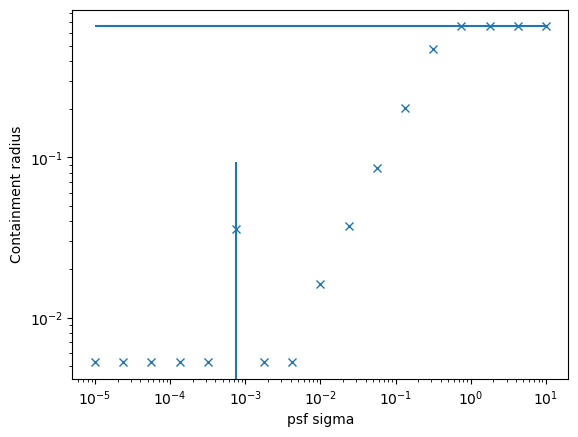

In [25]:
plt.errorbar(ss, vals, yerr = vals_std, fmt = 'x')
value_true = dataset_asimov_cl.psf.containment_radius_map(energy_true = 1*u.TeV).data.max()
plt.hlines(value_true, ss[0], ss[-1], ) 
plt.loglog()
plt.xlabel("psf sigma")
plt.ylabel("Containment radius")

In [61]:
psf_true = dataset_asimov_cl.psf#.containment_radius_map(energy_true = 1*u.TeV)#.plot(add_cbar = 1)

## AFter convolving

In [68]:
ss = np.logspace(-5,1, 7) - 1e-3
print(ss)
vals = []
with dataset_asimov.models.parameters.restore_status():
    for s in ss:
    
        dataset_asimov.models.parameters['sigma_psf'].value = s
        plt.figure()
        map_ =      dataset_asimov.npred_gaussian_psf_map()#.containment_radius_map(energy_true = 1*u.TeV)
        #cc = psf_true.convolve(map_)
        dataset_asimov.evaluators[dataset_asimov.models.names[0]].convolve_psf_map(map_)
        cc = dataset_asimov.evaluators[dataset_asimov.models.names[0]].psf
        print(cc.psf_kernel_map)
        
        #.containment_radius_map(energy_true = 1*u.TeV).plot(add_cbar = 1)
        val =cc.data[0][0]
        vals.append(val)
    

[-9.900e-04 -9.000e-04  0.000e+00  9.000e-03  9.900e-02  9.990e-01
  9.999e+00]
compute gaussian for  sigma 1e-3 +  -0.00099
WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (67, 67, 24)
	ndim  : 3
	unit  : 
	dtype : float32

compute gaussian for  sigma 1e-3 +  -0.0009
WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (67, 67, 24)
	ndim  : 3
	unit  : 
	dtype : float32

compute gaussian for  sigma 1e-3 +  0.0
WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (67, 67, 24)
	ndim  : 3
	unit  : 
	dtype : float32

compute gaussian for  sigma 1e-3 +  0.009000000000000001
WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (67, 67, 24)
	ndim  : 3
	unit  : 
	dtype : float32

compute gaussian for  sigma 1e-3 +  0.099
WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (67, 67, 24)
	ndim  : 3
	unit  : 
	dtype : float32

compute gaussian for  sigma 1e-3 +  0.999
WcsND

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

compute gaussian for  sigma 1e-3 +  1.898216284677845e-15


<WCSAxes: >

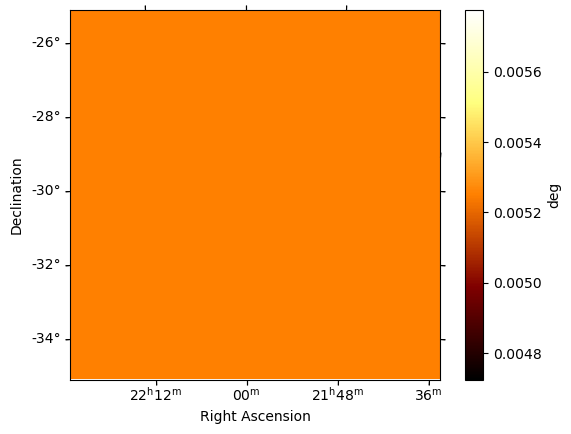

In [57]:
dataset_asimov.npred_gaussian_psf_map().containment_radius_map(energy_true = 1*u.TeV).plot(add_cbar = 1)

In [58]:
dataset_asimov.irf_model.psf_model.evaluate(geom = sigma_psf=0.1)

SyntaxError: invalid syntax (1070880157.py, line 1)

compute gaussian for  sigma 1e-3 +  0.0009999999999999998
compute gaussian for  sigma 1e-3 +  0.0014458231349729434
compute gaussian for  sigma 1e-3 +  0.0005868047114976443
compute gaussian for  sigma 1e-3 +  0.001043454203244322
compute gaussian for  sigma 1e-3 +  0.0009568584310683059
compute gaussian for  sigma 1e-3 +  0.0009999999999999998
compute gaussian for  sigma 1e-3 +  0.0002453173723494812
compute gaussian for  sigma 1e-3 +  0.00018553631519420362
compute gaussian for  sigma 1e-3 +  0.0001178672463258276
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  7.032356295185645e-05
compute gaussian for  sigma 1e-3 +  6.679951799004347e-05
compute gaussian for  sigma 1e-3 +  6.872760158432384e-05
compute gaussian for  sigma 1e-3 +  6.837519374308034e-05
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  0.00032375945989998974


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan


Position <SkyCoord (ICRS): (ra, dec) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within


compute gaussian for  sigma 1e-3 +  nan
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  6.872760158432384e-05
compute gaussian for  sigma 1e-3 +  6.837519374308034e-05
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  6.857093574371671e-05
compute gaussian for  sigma 1e-3 +  6.853165722356428e-05
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  6.872760158432384e-05
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  6.872760158432384e-05
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  6.872760158432384e-05
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  6.872760158432384e-05
compute gaussian for  sigma 1e-3 +  6.855129521089105e-05
compute gaussian for  sigma 1e-3 +  6.872760158432384e-05
compute gaussian for  sigma 1e-3

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

compute gaussian for  sigma 1e-3 +  2.8429787136659625e-12
compute gaussian for  sigma 1e-3 +  4.506082362711744e-13
compute gaussian for  sigma 1e-3 +  5.425374407109357e-12
compute gaussian for  sigma 1e-3 +  7.920719202053617e-16
compute gaussian for  sigma 1e-3 +  1.3893184694054386e-12
compute gaussian for  sigma 1e-3 +  8.038700103794524e-13
compute gaussian for  sigma 1e-3 +  9.210798993094723e-13
compute gaussian for  sigma 1e-3 +  4.4671672882069107e-13
compute gaussian for  sigma 1e-3 +  3.0631921033984903e-13
compute gaussian for  sigma 1e-3 +  2.1040516659694143e-13
compute gaussian for  sigma 1e-3 +  1.3542159418584305e-13
compute gaussian for  sigma 1e-3 +  9.09256507976644e-14
compute gaussian for  sigma 1e-3 +  6.057810037016914e-14


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

compute gaussian for  sigma 1e-3 +  1.7724061436184477e-12
compute gaussian for  sigma 1e-3 +  7.040301933016607e-13
compute gaussian for  sigma 1e-3 +  8.779423022018014e-12
compute gaussian for  sigma 1e-3 +  6.104638881638397e-12
compute gaussian for  sigma 1e-3 +  2.1259401543870237e-12
compute gaussian for  sigma 1e-3 +  9.327851561904272e-13
compute gaussian for  sigma 1e-3 +  6.057810037016914e-14
compute gaussian for  sigma 1e-3 +  1.4813670255742206e-14
compute gaussian for  sigma 1e-3 +  3.339812682055104e-14
compute gaussian for  sigma 1e-3 +  1.4813670255742206e-14


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

compute gaussian for  sigma 1e-3 +  6.829891223652899e-12
compute gaussian for  sigma 1e-3 +  5.616820436603158e-12
compute gaussian for  sigma 1e-3 +  2.1483717951333025e-12
compute gaussian for  sigma 1e-3 +  1.4940409223370214e-12
compute gaussian for  sigma 1e-3 +  6.613275667973623e-12
compute gaussian for  sigma 1e-3 +  5.42054386543523e-12
compute gaussian for  sigma 1e-3 +  1.4813670255742206e-14


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


compute gaussian for  sigma 1e-3 +  6226775012366886.0
compute gaussian for  sigma 1e-3 +  311338750618344.3
compute gaussian for  sigma 1e-3 +  15566937530917.217
compute gaussian for  sigma 1e-3 +  778346876545.8599
compute gaussian for  sigma 1e-3 +  38917343827.292046
compute gaussian for  sigma 1e-3 +  1945867191.3636527
compute gaussian for  sigma 1e-3 +  97293359.56723264
compute gaussian for  sigma 1e-3 +  4864667.977411626
compute gaussian for  sigma 1e-3 +  243233.39792057616
compute gaussian for  sigma 1e-3 +  12161.66894602368
compute gaussian for  sigma 1e-3 +  608.0824972968333
compute gaussian for  sigma 1e-3 +  1.4813670255742206e-14


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/env

compute gaussian for  sigma 1e-3 +  1.4813718394318666e-14
compute gaussian for  sigma 1e-3 +  1.481362200874553e-14
compute gaussian for  sigma 1e-3 +  1.481415196676744e-14
compute gaussian for  sigma 1e-3 +  1.481318854471697e-14
compute gaussian for  sigma 1e-3 +  1.4813670255742206e-14
compute gaussian for  sigma 1e-3 +  1.481318854471697e-14
compute gaussian for  sigma 1e-3 +  1.481800587180976e-14
compute gaussian for  sigma 1e-3 +  1.4808371976565705e-14
compute gaussian for  sigma 1e-3 +  1.481318854471697e-14
compute gaussian for  sigma 1e-3 +  1.4766260371563976e-14
compute gaussian for  sigma 1e-3 +  1.4579292309004065e-14
compute gaussian for  sigma 1e-3 +  1.411708380402721e-14
compute gaussian for  sigma 1e-3 +  1.2775129587007383e-14
compute gaussian for  sigma 1e-3 +  9.151308183463769e-15
compute gaussian for  sigma 1e-3 +  1.898216284677845e-15
compute gaussian for  sigma 1e-3 +  1.9881986139912157e-14
compute gaussian for  sigma 1e-3 +  8.516707738354112e-15
compute

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


compute gaussian for  sigma 1e-3 +  1.8982225730504453e-15
compute gaussian for  sigma 1e-3 +  1.8982099963052447e-15
compute gaussian for  sigma 1e-3 +  1.898279168403849e-15
compute gaussian for  sigma 1e-3 +  1.8981532925316235e-15
compute gaussian for  sigma 1e-3 +  1.898216284677845e-15
compute gaussian for  sigma 1e-3 +  1.8982225730504453e-15
compute gaussian for  sigma 1e-3 +  1.8982099963052447e-15
compute gaussian for  sigma 1e-3 +  1.898279168403849e-15
compute gaussian for  sigma 1e-3 +  1.8981532925316235e-15
compute gaussian for  sigma 1e-3 +  1.898216284677845e-15
compute gaussian for  sigma 1e-3 +  1.8982225730504453e-15
compute gaussian for  sigma 1e-3 +  1.8982099963052447e-15
compute gaussian for  sigma 1e-3 +  1.898279168403849e-15
compute gaussian for  sigma 1e-3 +  1.8981532925316235e-15
compute gaussian for  sigma 1e-3 +  1.898216284677845e-15
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed.
	nfev   

<Axes: >

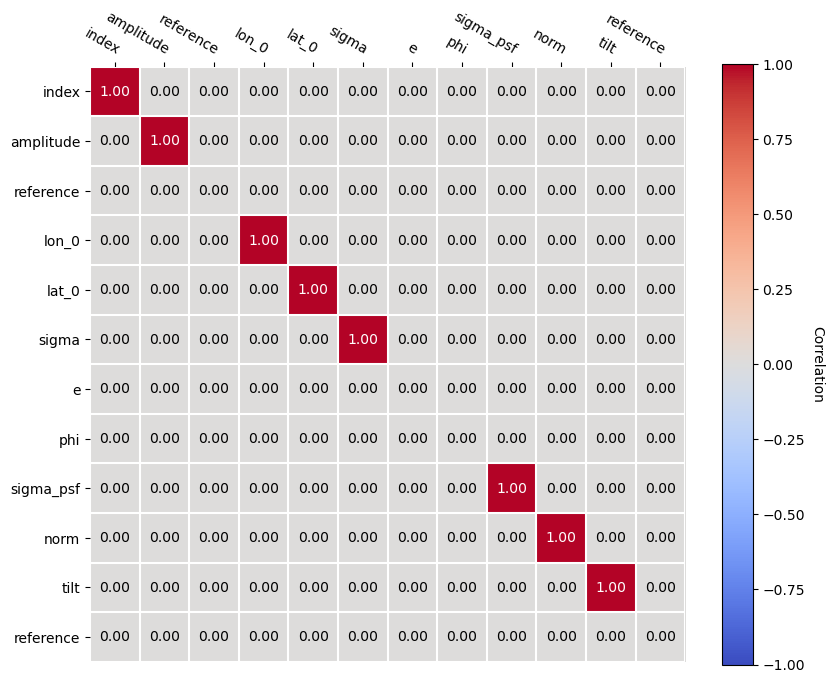

In [10]:
%%time
fit = Fit()
result = fit.run(dataset_asimov)
print(result)
dataset_asimov.models.covariance = fit.covariance(dataset_asimov).matrix
dataset_asimov.models.covariance.plot_correlation()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 88
	total stat : 851228.65

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 15.7 s, sys: 2.13 s, total: 17.8 s
Wall time: 17.9 s


<Axes: >

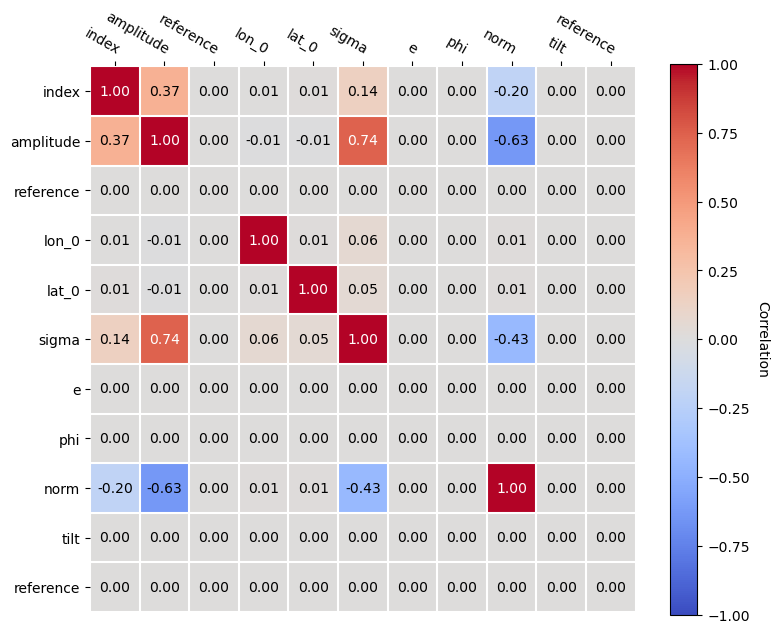

In [11]:
%%time
fit_cl = Fit()
result_cl = fit_cl.run(dataset_asimov_cl)
print(result_cl)
dataset_asimov_cl.models.covariance = fit_cl.covariance(dataset_asimov_cl).matrix
dataset_asimov_cl.models.covariance.plot_correlation()

In [12]:
print(dataset_asimov.models.parameters.to_table())

   type      name      value         unit        error      min        max     frozen is_norm is_penalised link
--------- --------- ----------- -------------- --------- ---------- ---------- ------ ------- ------------ ----
 spectral     index  1.2997e+01                      nan        nan        nan  False   False        False     
 spectral amplitude -7.6580e-03 cm-2 s-1 TeV-1       nan        nan        nan  False    True        False     
 spectral reference  1.0000e+00            TeV 0.000e+00        nan        nan   True   False        False     
  spatial     lon_0  3.2874e+02            deg       nan  3.287e+02  3.307e+02  False   False        False     
  spatial     lat_0 -3.0570e+01            deg       nan -3.122e+01 -2.922e+01  False   False        False     
  spatial     sigma  2.3423e+08            deg       nan  0.000e+00        nan  False   False        False     
  spatial         e  0.0000e+00                0.000e+00  0.000e+00  1.000e+00   True   False        Fal

In [13]:
print(dataset_asimov_cl.models.parameters.to_table())

  type      name      value         unit        error      min        max     frozen is_norm is_penalised link
-------- --------- ----------- -------------- --------- ---------- ---------- ------ ------- ------------ ----
spectral     index  2.3000e+00                2.088e-01        nan        nan  False   False        False     
spectral amplitude  1.0000e-12 cm-2 s-1 TeV-1 5.025e-13        nan        nan  False    True        False     
spectral reference  1.0000e+00            TeV 0.000e+00        nan        nan   True   False        False     
 spatial     lon_0  3.2968e+02            deg 2.349e-01  3.287e+02  3.307e+02  False   False        False     
 spatial     lat_0 -3.0222e+01            deg 2.018e-01 -3.122e+01 -2.922e+01  False   False        False     
 spatial     sigma  5.0000e-01            deg 1.493e-01  0.000e+00        nan  False   False        False     
 spatial         e  0.0000e+00                0.000e+00  0.000e+00  1.000e+00   True   False        False     
 

In [14]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    
    return ax

def plot_par_one(par1,x,  label,ax, fmt ='x', markersize = 6):
    ax.errorbar(x = x, y = par1.value, yerr = par1.error, fmt= fmt,
                markersize = markersize,
                label = label,
               alpha = 0.7)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])
            except:
                pass

    plt.tight_layout()
    ax[0].legend()
    
def plot_source_par_one(model_name, pars):
    fig, ax = plt.subplots(4,int(len(pars)/3), figsize = (6, 9))
    ax= ax.flatten()
    xx = [0]*len(pars)
    x2 = [0,0.5]    
    for i, p in enumerate(pars):
        for j, m in enumerate (models_list):
            try:
            
                plot_par_one(m.parameters[p],
                         x = xx[i]+ x2[j],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j])
                ax[i].hlines(dataset_input.models.parameters[p].value, -0.5, 1.)
            except:
                pass

    plt.tight_layout()
    ax[i].legend()
    for a in ax:
        a.set_xlim(-0.5,1)

labels = ['with PSF nuis' , 'st']
fmts = ['o','x', '*'] * 3
markersize = [6,10, 11] * 3

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


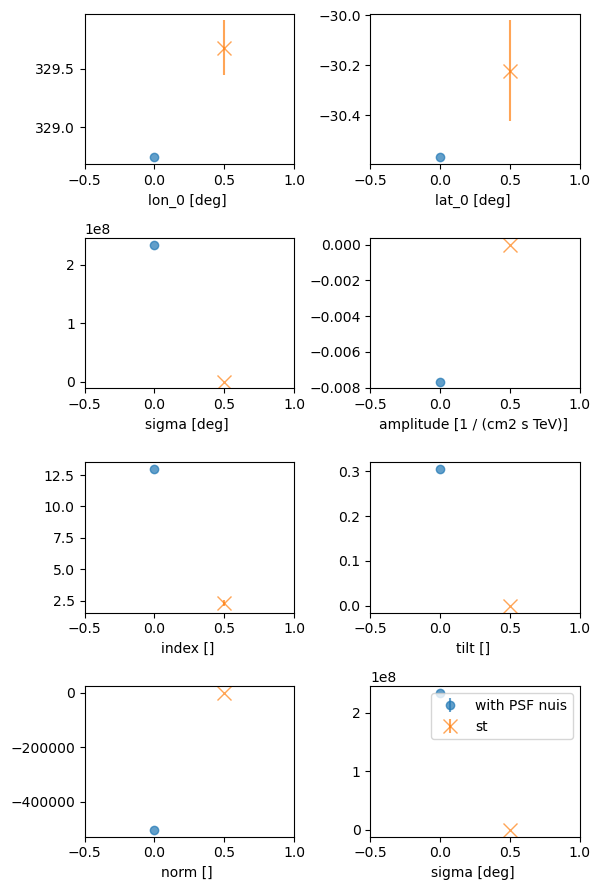

In [15]:
models_list = [dataset_asimov.models,  dataset_asimov_cl.models, ]

pars =  pars = ['lon_0', 'lat_0' , 'sigma', 'amplitude', 'index','tilt', 'norm', 'sigma']
plot_source_par_one(0, pars)


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


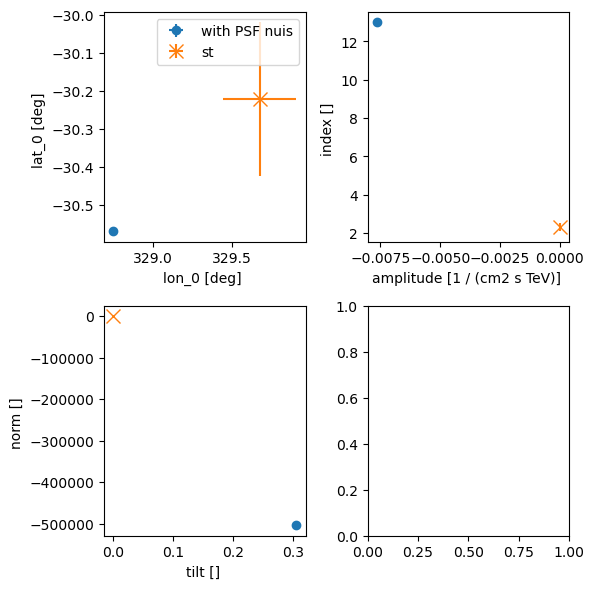

In [16]:
models_list = [dataset_asimov.models,  dataset_asimov_cl.models, ]
/
pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'), ('tilt', 'norm')]
plot_source_par(0, pars)


In [17]:
dataset_asimov.models[0].spatial_model.plot()

MemoryError: Unable to allocate 873. GiB for an array with shape (117117066385,) and data type float64

In [18]:
config = Dataset_load.load_config()
colors = config['colors']['one']

color_standard = colors[0]; color_standard_e = colors[2] #mediumvioletred
color_nui = colors[1]; color_nui_e = colors[3]
color_input = 'darkorange'
color_rnd = 'darkgreen'


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/modeling/models/spectral.py:522: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log", nonpositive="clip")


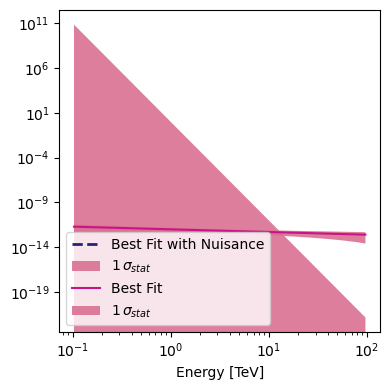

In [19]:


fig,axs = plt.subplots(1,1, sharey=True,figsize = (4,4))
axs = [ axs]

energy_bounds = [0.1,100]*u.TeV
ax = axs[0]

dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color=color_nui,
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor=color_standard_e,
                                                          alpha = 0.9,
                                                          label= "1$\,\sigma_{stat}$"
                                                         )

dataset_asimov_cl.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = color_standard)
dataset_asimov_cl.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax =ax,
                                                       facecolor=color_standard_e,
                                                          alpha = 0.9,
                                                          label= "1$\,\sigma_{stat}$"
                                                         )
axs[0].legend(loc='lower left')
#axs[0].set_ylim(5e-14,3e-12) 
axs[0].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()


(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

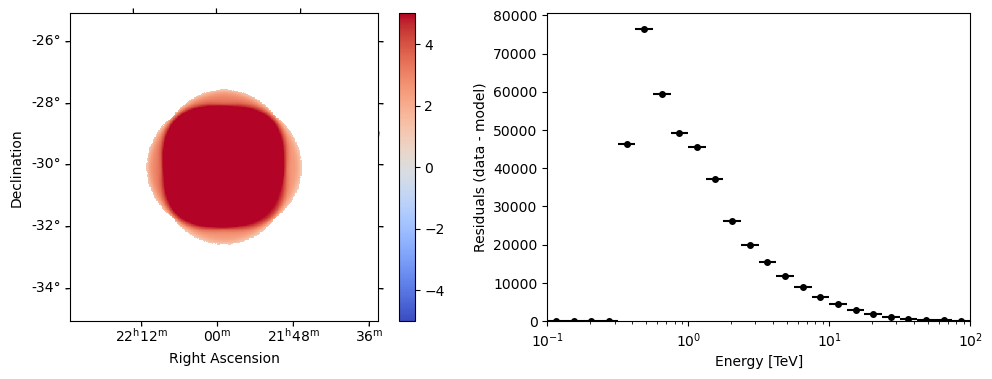

In [20]:
dataset_asimov.plot_residuals()

In [ ]:
ss = dataset_asimov.stat_sum() 
print(ss)

In [ ]:
ss_cl = dataset_asimov_cl.stat_sum() 
print(ss_cl)

In [ ]:
with dataset_asimov.models.parameters.restore_status():
    dataset_asimov.models.parameters['amplitude'].value = 0
    print(np.sqrt(dataset_asimov.stat_sum()    -ss))

In [ ]:
with dataset_asimov_cl.models.parameters.restore_status():
    dataset_asimov_cl.models.parameters['amplitude'].value = 0
    print(np.sqrt(dataset_asimov_cl.stat_sum()    -ss_cl))